# Poverty in Paris urban area

In [1]:
from pynsee.localdata import get_local_metadata, get_nivgeo_list, get_area_list, get_included_area, get_local_data
from pynsee.geodata import get_geodata, get_geodata_list

import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
import re

In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [3]:
# get a list all data available : datasets and variables
metadata = get_local_metadata()

# geographic metadata
nivgeo = get_nivgeo_list()

# get geographic area list
area = get_area_list()

# get all communes in Paris urban area
areaParis = get_included_area('unitesUrbaines2020', ['00851'])
areaParis = areaParis[areaParis['type'].isin(['ArrondissementMunicipal', 'Commune'])]

# get selected communes identifiers
code_com_paris = areaParis.code.to_list()

This function renders only package's internal data, it might not be the most up-to-date.
Have a look at api.insee.fr !
This function renders only package's internal data, it might not be the most up-to-date.
Have a look at api.insee.fr !
Locally saved data has been used
Set update=True to trigger an update


/tmp/ipykernel_939/3253631726.py:11: DeprecationWarning: This function is deprecated.
Please, use get_descending_area instead.
  areaParis = get_included_area('unitesUrbaines2020', ['00851'])
  0%|          | 0/1 [00:00<?, ?it/s]

Locally saved data has been used
Set update=True to trigger an update
Existing environment variables used, instead of locally saved credentials


100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


In [4]:
code_com_paris = [c for c in code_com_paris if re.match("^75|^93|^94|^92", c)]
len(code_com_paris)

144

In [7]:
# get numeric values from INSEE database 
dataParis = get_local_data(dataset_version='GEO2020FILO2017',
                       variables =  'INDICS_FILO_DISP_DET',
                       nivgeo = 'COM',
                       update=True,
                       geocodes = code_com_paris)

#select poverty rate data, exclude paris commune
data_plot = dataParis.loc[dataParis.UNIT=='TP60']
data_plot = data_plot.loc[data_plot.CODEGEO!='75056']

# get geographical data list
geodata_list = get_geodata_list()

# get departments geographical limits
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')
comIdf = com[com['insee_reg'] == '11']
comIdf = comIdf[['id', 'nom_m', 'insee_com', 'geometry']]
comIdf = comIdf.rename(columns={'insee_com': 'CODEGEO'})

# get arrondissement geographical limits
arr = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_municipal')
arr75 = arr[arr.insee_com.str.startswith('75')]
arr75 = arr75[['id', 'nom_m', 'insee_arm', 'geometry']]
arr75 = arr75.rename(columns={'insee_arm': 'CODEGEO'})

# make ile de frande map by concatenation
mapidf = pd.concat([comIdf, arr75]).reset_index()

Getting data: 100%|██████████| 144/144 [02:42<00:00,  1.13s/it]

Data saved: /home/onyxia/.cache/pynsee/pynsee/866f22f3c76379825dd51fa1d56b7f36
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/2ac583be54e866b2b1b30fb0113c1fd0
Set update=True to get the most up-to-date data



/opt/mamba/lib/python3.11/site-packages/pynsee/localdata/get_local_data.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_final = pd.concat(list_data_all).reset_index(drop=True)


Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/2b13d6d19b4aa50c659568eb489660b0
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/cf8a26c6895d190238f3815b59e91470
Set update=True to get the most up-to-date data


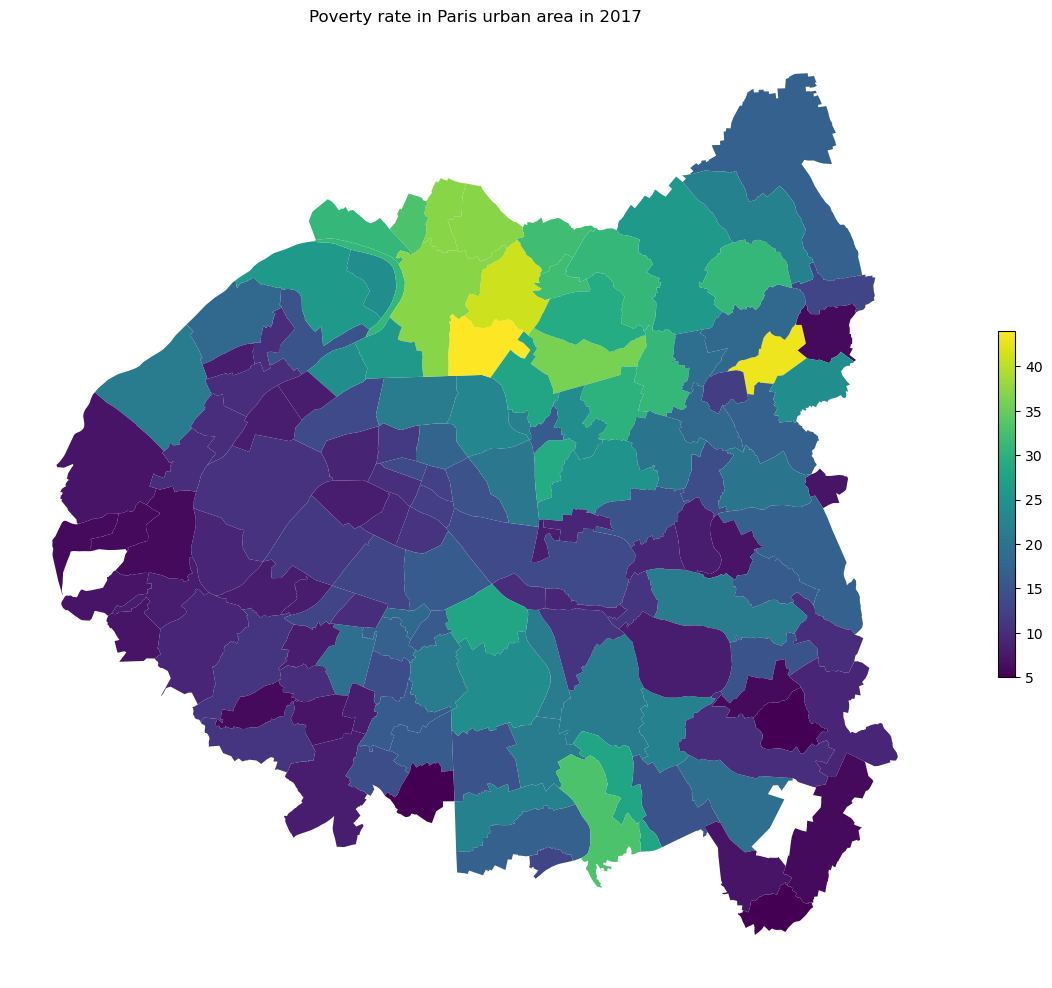

In [8]:
# merge values and geographic limits
mapparis = mapidf.merge(data_plot, how = 'right', on = 'CODEGEO')
mapparis = gpd.GeoDataFrame(mapparis).set_crs("EPSG:4326")

#plot
fig, ax = plt.subplots(1,1,figsize=(15,15))
mapparis.plot(column='OBS_VALUE', cmap=cm.viridis,  aspect=1,
    legend=True, ax=ax, legend_kwds={'shrink': 0.3})
ax.set_axis_off()
ax.set(title='Poverty rate in Paris urban area in 2017')
plt.show()
fig.savefig('poverty_paris_urban_area.svg',
            format='svg', dpi=1200,
            bbox_inches = 'tight',
            pad_inches = 0)